In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200


from tqdm.auto import tqdm as pbar

import logging
from importlib import reload

from ihrem import timeslice
from ihrem.timeslice import ms
from ihrem import paths
from ihrem.analysis import stim
from ihrem.analysis import cycles

from ihrem.figs_cpg import fig1, edf2

import warnings

warnings.simplefilter(action='error', category=FutureWarning)
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.WARNING)


paths = reload(paths)
reg_full = paths.Registry.read_excel()

In [3]:
fig1 = reload(fig1)

fig1.report_noisy(
    reg_full.sel_mask(
        reg_full['state'].isin(['sleep', '48h', '24h'])
        & (reg_full['lesion'] != 'BST')
        & reg_full.is_bilat('CLA')
    )
)

  0%|          | 0/136 [00:00<?, ?it/s]

66/721 pulses labeled as noisy (9.15%)


noisy                                      False  True 
stim         state lesion pulse_len cap                
light pulses sleep amyg   30000.0   none      22      0
                          60000.0   none      10      0
                   ctx    30000.0   none       1      0
                          45000.0   none       1      0
                          60000.0   none       3      0
                   none   10.0      none      48      0
                          500.0     none      23      0
                          1000.0    bilat     74     15
                                    left      61     11
                                    none      84     10
                                    right    101     30
                          5000.0    none      11      0
                          30000.0   none      91      0
                          45000.0   none      41      0
                          60000.0   none      18      0
                          90000.0   none      66      0

In [4]:
stim = reload(stim)

    

simple_protocol = edf2.is_full_night_simple_protocol(reg_full)
simple_protocol.value_counts()

contains_noisy_pulses = reg_full.index.isin([exp_name for exp_name, pulse_idx in stim.NOISY_PULSES])


reg_sel_multi = {
    'unstim_sleep': reg_full.sel_mask(
        reg_full['stim'].isna()
        & reg_full['state'].isin(['sleep', '48h', '24h'])
        & (reg_full['lesion'] != 'BST')
        & reg_full['cap'].isna()
        & reg_full.is_bilat('CLA')
        & (~contains_noisy_pulses)
    ),

    '1s_pulses_no-cap': reg_full.sel_mask(
        reg_full['stim'].isin(['light pulses'])
        & reg_full['state'].isin(['sleep'])
        & (reg_full['lesion'] != 'BST')
        & reg_full['cap'].isna()
        & reg_full.is_bilat('CLA')
        & simple_protocol
        & (~contains_noisy_pulses)
    ),

    '1s_pulses_unilat-cap': reg_full.sel_mask(
        reg_full['stim'].isin(['light pulses'])
        & reg_full['state'].isin(['sleep'])
        & (reg_full['lesion'] != 'BST')
        & reg_full['cap'].isin(['left', 'right'])
        & reg_full.is_bilat('CLA')
        & simple_protocol
        & (~contains_noisy_pulses)
    ),
}

  0%|          | 0/204 [00:00<?, ?it/s]

In [5]:
for k in reg_sel_multi.keys():
    print(k, len(reg_sel_multi[k].value_counts('animal')), 'animals', reg_sel_multi[k].value_counts('animal').sum(), 'recordings')
    
    
total = pd.concat([reg.reg for reg in reg_sel_multi.values()])

assert total.index.is_unique

print('total', len(total.value_counts('animal')), 'animals', total.value_counts('animal').sum(), 'recordings')

unstim_sleep 20 animals 34 recordings
1s_pulses_no-cap 2 animals 3 recordings
1s_pulses_unilat-cap 3 animals 6 recordings
total 23 animals 43 recordings


In [6]:
total_light_wins = stim.load_light_wins_multi(
    paths.Registry(pd.concat([reg_sel_multi['1s_pulses_no-cap'].reg, reg_sel_multi['1s_pulses_unilat-cap'].reg])),
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:

    
sleep_stats = pd.concat({
    desc: edf2.collect_sleep_stats(reg_sel)
    for desc, reg_sel in pbar(reg_sel_multi.items())
},
    axis=0,
    names=['dataset', 'exp_name']
)


sleep_stats

  0%|          | 0/3 [00:00<?, ?it/s]

load beta:   0%|          | 0/34 [00:00<?, ?it/s]

rem wins:   0%|          | 0/34 [00:00<?, ?it/s]

load beta:   0%|          | 0/3 [00:00<?, ?it/s]

rem wins:   0%|          | 0/3 [00:00<?, ?it/s]

load beta:   0%|          | 0/6 [00:00<?, ?it/s]

rem wins:   0%|          | 0/6 [00:00<?, ?it/s]

when                                           global                          \
metric                                     rem_median sws_median cycle_median   
dataset              exp_name                                                   
unstim_sleep         GL957_20201005           56000.0    53000.0     109000.0   
                     GL660_20191114           52000.0    78500.0     137000.0   
                     GL1003_20201031          76500.0    52250.0     130500.0   
                     GL1003_20201101          82250.0    46500.0     128500.0   
                     GL1003_20201102          82000.0    47000.0     131000.0   
                     GL598_20191205           85000.0    52500.0     143500.0   
                     GL1071_20210709          57500.0    58500.0     118000.0   
                     GL1071_20210710          53000.0    60000.0     116500.0   
                     GL1071_20210711          59250.0    60500.0     120000.0   
                     GL1018_20210811          60000.0    58500.0     121500.0   
                     GL1018_20210812          66750.0    55000.0     122000.0   
                     GL1018_20210813          75500.0    48750.0     126250.0   
                     GL1234_20211208          62500.0    60750.0     130250.0   
                     GL1234_20211210          70000.0    65250.0     135750.0   
                     GL1076_20210426          66000.0    55500.0     124500.0   
                     GL1120                   55750.0    85000.0     143000.0   
                     GL1077_20210507          76250.0    31000.0     117500.0   
                     GL1077_20210509          61000.0    66500.0     128500.0   
                     GL1077_20210512          61250.0    66000.0     127750.0   
                     GL1087_20210515          37500.0    84500.0     127500.0   
                     GL1087_20210517          45000.0    76500.0     126500.0   
                     GL1111_20210530          62500.0    72500.0     133000.0   
                     GL1107_20210609          59000.0    69000.0     127500.0   
                     GL1068_20210701          34500.0    76000.0     118500.0   
                     GL894_20201112           56250.0    87500.0     145250.0   
                     GL594_20200620           60500.0    68500.0     131500.0   
                     GL939_20200710           65250.0    75000.0     143000.0   
                     GL903_20200716           67000.0    75000.0     147000.0   
                     GL903_20200718           80750.0    61500.0     143250.0   
                     GL903_20200720           77250.0    58500.0     139000.0   
                     GL1087_20210525          56000.0    66000.0     124000.0   
                     GL1353_20230623_sleep    73000.0    53000.0     124500.0   
                     GL1380_20230725_sleep    80000.0    51500.0     130000.0   
                     GL1380_20230728_sleep    75750.0    41000.0     118500.0   
1s_pulses_no-cap     GL1353_20230626_sleep    75250.0    56500.0     134500.0   
                     GL1353_20230703_sleep    70000.0    61500.0     132000.0   
                     GL1619_20231026_sleep    70250.0    48750.0     119500.0   
1s_pulses_unilat-cap GL1576_20230920_sleep    83500.0    52000.0     138500.0   
                     GL1619_20231028_sleep    74000.0    51500.0     129000.0   
                     GL1619_20231102_sleep    69500.0    45500.0     118000.0   
                     GL1630_20240425_sleep    81500.0    65000.0     148000.0   
                     GL1630_20240511_sleep    76500.0    76750.0     155000.0   
                     GL1630_20240512_sleep    76000.0    77000.0     153500.0   

when                                                                \
metric                                     duty_median cycle_count   
dataset              exp_name                                        
unstim_sleep         GL957_20201005           0.473988       26

# EDF 2ab: stats across protocols

Saving: /gpfs/laur/data/fenkl/from_luis/fig1/stats/durations_global.pdf


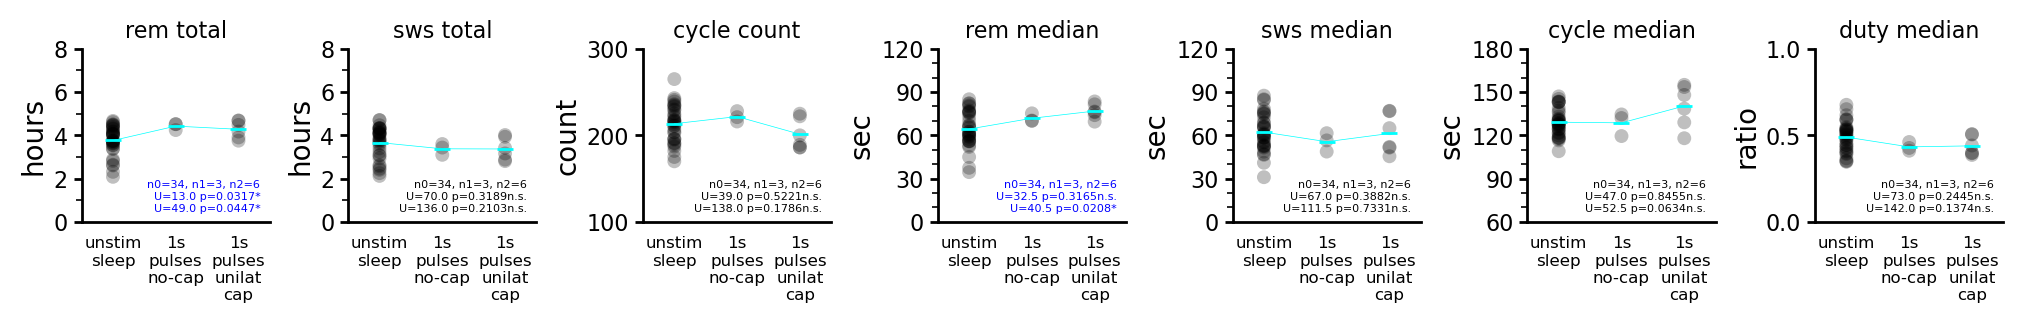

In [8]:
f = edf2.plot_durations_global(reg_sel_multi, sleep_stats)

fig1.savefig(f, f'stats/durations_global')


# EDF 2c: stats across night

In [9]:


f = edf2.plot_durations_across_night(reg_sel_multi, sleep_stats)

fig1.savefig(f, f'stats/durations_across_night')


Saving: /gpfs/laur/data/fenkl/from_luis/fig1/stats/durations_across_night.pdf


# Revision: Corr of REM with surrounding SWS?

In [10]:
timeslice = reload(timeslice)
cycles = reload(cycles)

reg_sel = reg_sel_multi['unstim_sleep']

exp_beta_detailed = reg_sel.load_all_beta_traces_multi(area='CLA').normalize_by_quantiles()

exp_beta_comb = exp_beta_detailed.groupby_max('exp_name')

exp_rem_wins = cycles.extract_rem_wins_multi(exp_beta_comb)

load beta:   0%|          | 0/34 [00:00<?, ?it/s]

rem wins:   0%|          | 0/34 [00:00<?, ?it/s]

In [11]:
ref_cat = 'rem'

length_range = (ms(seconds=30), ms(minutes=2))

lengths_shifted = edf2.take_lengths_shifted(exp_rem_wins, ref_cat, shifts=np.arange(-5, +9), length_range=length_range)

all_corrs = edf2.calc_length_corrs(lengths_shifted)

all_corrs

-5        -4        -3        -2        -1    0  \
GL957_20201005        -0.114646  0.351697 -0.093101  0.151100 -0.243568  1.0   
GL660_20191114        -0.048480  0.132442 -0.103073 -0.102417 -0.044242  1.0   
GL1003_20201031       -0.054436 -0.011492  0.006773  0.159935 -0.054515  1.0   
GL1003_20201101        0.103384 -0.041176  0.091021  0.003802 -0.284881  1.0   
GL1003_20201102        0.007264 -0.051067  0.026284  0.141368 -0.103546  1.0   
GL598_20191205         0.107557 -0.020238 -0.044657  0.147989 -0.406730  1.0   
GL1071_20210709       -0.097131  0.130449 -0.116900  0.072514 -0.316819  1.0   
GL1071_20210710       -0.111017  0.008496 -0.061470  0.077714 -0.359308  1.0   
GL1071_20210711       -0.219385  0.202537 -0.176183  0.228967 -0.311140  1.0   
GL1018_20210811       -0.023466  0.071143 -0.015004  0.080727 -0.364315  1.0   
GL1018_20210812        0.055503 -0.050964 -0.104899  0.114283 -0.343088  1.0   
GL1018_20210813       -0.062105  0.172925 -0.161230  0.209382 -0.331701  1.0   
GL1234_20211208       -0.075811 -0.016105 -0.091611  0.247971 -0.194902  1.0   
GL1234_20211210       -0.040291  0.109166 -0.066960  0.153236 -0.286827  1.0   
GL1076_20210426       -0.146302  0.089034 -0.163766  0.037790 -0.219134  1.0   
GL1120                 0.007509  0.103819 -0.028448 -0.103895 -0.057375  1.0   
GL1077_20210507        0.045292  0.005146  0.024519 -0.015680 -0.125976  1.0   
GL1077_20210509        0.094621  0.077901  0.012698  0.000263 -0.084391  1.0   
GL1077_20210512       -0.090597  0.033289  0.026200  0.169513 -0.199163  1.0   
GL1087_20210515       -0.244098  0.192871 -0.058229  0.161886 -0.247374  1.0   
GL1087_20210517        0.057777 -0.050846  0.107006  0.114432 -0.189717  1.0   
GL1111_20210530       -0.041501  0.030380 -0.041815  0.185386 -0.388237  1.0   
GL1107_20210609        0.018198  0.164483 -0.050470  0.011906 -0.085761  1.0   
GL1068_20210701        0.020803  0.012818 -0.133658  0.071059 -0.275583  1.0   
GL894_20201112        -0.105238  0.326714  0.089930  0.272083 -0.017434  1.0   
GL594_20200620        -0.198609  0.021152 -0.127412  0.028509 -0.271708  1.0   
GL939_20200710        -0.093101  0.105314  0.011956  0.075821 -0.188378  1.0   
GL903_20200716        -0.045320  0.139270  0.020478  0.116428 -0.138352  1.0   
GL903_20200718         0.012138  0.043221  0.103192  0.077845 -0.203244  1.0   
GL903_20200720         0.058025  0.094847 -0.027753  0.112852 -0.234185  1.0   
GL1087_20210525        0.004518  0.115110  0.011057  0.142485  0.077673  1.0   
GL1353_20230623_sleep -0.069367  0.156263  0.044234 -0.041606 -0.231761  1.0   
GL1380_20230725_sleep -0.027931  0.072497 -0.091801  0.260654 -0.207202  1.0   
GL1380_20230728_sleep -0.072680  0.075988 -0.177488  0.078410 -0.243454  1.0   

                              1         2         3         4         5  \
GL957_20201005        -0.180586  0.151100 -0.165786  0.351697 -0.151325   
GL660_20191114        -0.019464 -0.102417 -0.153841  0.132442 -0.222738   
GL1003_20201031       -0.253621  0.159935 -0.032266 -0.011492 -0.216843   
GL1003_20201101       -0.215747  0.003802 -0.069670 -0.041176  0.147357   
GL1003_20201102       -0.132732  0.141368 -0.083660 -0.051067 -0.075162   
GL598_20191205         0.003086  0.147989 -0.014385 -0.020238 -0.208179   
GL1071_20210709       -0.351680  0.072514 -0.183273  0.130449 -0.113519   
GL1071_20210710       -0.419810  0.077714  0.003802  0.008496 -0.082911   
GL1071_20210711       -0.411527  0.228967 -0.167935  0.202537 -0.182691   
GL1018_20210811       -0.344955  0.080727 -0.107366  0.071143 -0.042382   
GL1018_20210812       -0.379148  0.114283 -0.164009 -0.050964 -0.112248   
GL1018_20210813       -0.366611  0.209382 -0.120583  0.172925 -0.143575   
GL1234_20211208       -0.183226  0.247971  0.023714 -0.016105 -0.059085   
GL1234_20211210       -0.258939  0.153236 -0.146776  0.109166 -0.111072   
GL1076_20210426       -0.228154  0.037790 -0.033355  0.089034  0.005807   
GL1120                -0.149

In [12]:
f = edf2.plot_all_corrs(all_corrs, ref_cat=ref_cat)

fig1.savefig(f, f'stats/rem_corr_summary')
# plot_all_corrs(all_corrs_shuffle.loc[:, -9:], ref_cat=ref_cat)


Saving: /gpfs/laur/data/fenkl/from_luis/fig1/stats/rem_corr_summary.pdf


In [13]:

for exp_name in pbar(['GL1071_20210711']):
    f = edf2.plot_lengths(
        lengths_shifted[exp_name],
        ref_cat,
        length_range,
    )
    
    f.suptitle(exp_name)
    
    fig1.savefig(f, f'stats/rem_corr_{exp_name}')

  0%|          | 0/1 [00:00<?, ?it/s]

Saving: /gpfs/laur/data/fenkl/from_luis/fig1/stats/rem_corr_GL1071_20210711.pdf
